In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
import math
import random
# %matplotlib qt
# Assignment drive link: https://drive.google.com/open?id=1_ir-I2iH6g41dB25xGHKuZu4s7bQZ0aN

## 1) DLT


### Part(a)

Following are the helper functions for performing Direct Linear Transform.

#### DLT
        - This function takes corresponding image and world points and computes the camera projection matrix.
        - We know that
$$ \begin{bmatrix}
u\\
v\\
w\\
\end{bmatrix} = P * \begin{bmatrix}
X\\
Y\\
Z\\
1
\end{bmatrix}$$
    - Given
$$ P_{i} = i^{th} Row Of P  $$
$$ pixel\_2D =
\begin{bmatrix}
u\\
v\\
w\\
\end{bmatrix} $$
$$ point\_3D =
\begin{bmatrix}
X\\
Y\\
Z\\
1
\end{bmatrix} $$
    - We get the following
$$ u = P_{1}.T*point\_3D / P_{3}.T*point\_3D $$
$$ u* P_{3}.T*point\_3D = P_{1}.T*point\_3D  $$
$$ P_{1}.T*point\_3D - u* P_{3}.T*point\_3D = 0 $$

    - Next, we write the above in the form of a matrix wherein each point gives us 2 equations to solve. We have 12 camera parameters. So we need 6 points at least. Make sure these points do not lie on the same plane. But we have 11 degrees of freedom.
    - We make the following matrix for each point and stack them:
    
$$ \begin{bmatrix}
X & Y & Z & 1 & 0 & 0 & 0 & 0 & -u*X & -u*Y & -u*Z & -u \\
0 & 0 & 0 & 0 & X & Y & Z & 1 & -v*X & -v*Y & -v*Z & -v
\end{bmatrix} $$
    - Later, since all the points will not give us the exact solution to minimize the above error we perform singular value decomposition of the matrix obtained from above and take the lowest eigen vector obtained. This gives us our camera projection matrix.

In [2]:
def decompositionRQ(H):
    '''
    Function to perform RQ decomposition
    Input:
        H - 3 x 3
    Returns:
        R - 3 x 3 - Upper triangular matrix
        Q - 3 x 3 - Orthogonal matrix
    '''
    Q, R = np.linalg.qr(np.flipud(H).T)
    Q = Q.T
    R = np.flipud(R.T)
    R = R[:, ::-1]
    Q = Q[ ::-1, :]
    return R, Q

def decompositionProjectionMatrix(P):

    '''
    Function to decompose projection matrix

    Input:
        P - 3 x 4 - Camera projection matrix
    Returns:
        K - 3 x 3 - Camera intrinsic matrix
        R - 3 x 3 - Rotation matrix
        C - 3 x 1 - Camera center
    '''

    KRMatrix = P[:,:3]
    C = - np.linalg.inv(KRMatrix) @ P[:,3]
    K, R = decompositionRQ(KRMatrix)
    K = K / K[2,2]
    return K, R, C

def DLT(pixels_2D, points_3D):
    '''
    Function to find camera parameters using Direct Linear Transform algorithm

    Input:
        pixels_2D - 2 x N - Pixel values
        points_3D - 3 x N - World points
    
    Returns:
        projectionMatrix - 3 x 4 - Camera projection matrix
        error - scalar - RMSE reprojection error 
    '''

    for i in range(pixels_2D.shape[0]):
        
        # Extracting image pixels
        u = pixels_2D[i, 0]
        v = pixels_2D[i, 1]

        # Extracting world points for corresponding image pixels
        X = points_3D[i, 0]
        Y = points_3D[i, 1]
        Z = points_3D[i, 2]

        Camarray = np.array([[X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u],
                             [0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v]])

        if i == 0:
            pointMatrix = Camarray
        else: 
            pointMatrix = np.vstack((pointMatrix, Camarray))


    U, D, Vt = np.linalg.svd(pointMatrix)
    # print(Vt.shape)
    P = Vt[-1, :]
#     print(P.shape)
    P.shape = (12, 1)
    error = np.sqrt(np.sum(np.square(pointMatrix @ P)))
    P = np.reshape(P, (3, 4))
    # P = P / P[2,3]
    return P, error

### Part(b) DLT with RANSAC

#### Method
    - We have our DLT function to compute projection matrix. 
    - Next, we have to randomly sample sets of 6-8 points that would give us the best projection matrix that minimizes the over all reprojection error. This ensures that no outliers are used to find the camera projection matrix.
    - We choose the Projection matrix which gives the lowest reprojection error. 

In [3]:
def DLT_RANSAC_optim(pixels_2D, points_3D, iterations, threshold = 0.1):
    '''
    Function to find camera parameters using Direct Linear Transform algorithm including RANSAC

    Input:
        pixels_2D - 2 x N - Pixel values
        points_3D - 3 x N - World points
    
    Returns:
        projectionMatrix - 3 x 4 - Camera projection matrix 
    '''
    inliers_max = 0
    
    homogeneousPoints_3D = np.hstack((points_3D, np.ones((points_3D.shape[0], 1))))
    for i in range(iterations):
        idx = np.random.randint(pixels_2D.shape[0], size = 10)
        P, errorP = DLT(pixels_2D[idx, :], points_3D[idx,:])
        reprojectedPoints = P @ homogeneousPoints_3D.T
        reprojectedPoints = reprojectedPoints / reprojectedPoints[2,:]
        reprojectionError = np.sqrt(np.mean(np.square(pixels_2D.T - reprojectedPoints[:2, :]), axis = 0))
        inliers = np.sum(reprojectionError < threshold)

        if inliers > inliers_max:
            inliers_max = inliers
            error = errorP
            optimP = P
    print(inliers_max)
    return optimP, error

In [4]:
def eulerAnglesToRotationMatrix(theta):
    '''
    Function to convert euler angles to rotation matrix
    '''
#     R_x = np.array([[1,0,0],[0,math.cos(theta[0]),-math.sin(theta[0])],[0,math.sin(theta[0]), math.cos(theta[0])]])
#     R_y = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[-math.sin(theta[1]),0,math.cos(theta[1])]])             
#     R_z = np.array([[math.cos(theta[2]),-math.sin(theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])
#     R = np.dot(R_z,np.dot(R_y,R_x))
    R = cv2.Rodrigues(theta)[0]
    return R

def reprojectedImage(image, rvecs, tvecs):
    
    R = (eulerAnglesToRotationMatrix(r))
    world_points_1 = np.hstack((x.reshape(pointsX * pointsY,1),y.reshape(pointsX * pointsY,1),np.zeros((pointsX * pointsY,1)),np.ones((pointsX * pointsY,1)))).astype(np.float32)
#     print(K)
    temp1 = np.zeros((3,4))
    temp1[:3,:3] = R
#     print(tvecs[testImage])
    temp1[:,3] = tvecs[:,0]
    P = K @ temp1
    P = P/P[2,3]
#     print(world_points_1.T)
    projected_points = []
    projected_points_ = (P @ world_points_1.T)
    projected_points_ = projected_points_ / projected_points_[2,:]
    projected_points = projected_points_[:2,:].T
    plt.figure()
    ## Wireframe
    idx = []

    for i in range(1, pointsY + 1):
        idx.append((i * pointsX) - 1)
    
    q = 0
    p = 0
    
    for i in range(projected_points.shape[0]):
        if (i == idx[q]):
            q = q + 1
            continue
        plt.plot([projected_points[i][0],projected_points[i+1][0]],[projected_points[i][1],projected_points[i+1][1]],'ro-')
    for i in range(pointsY):
        i1 = i
        j =  i + pointsX
        while(j < pointsX * pointsY):
            plt.plot([projected_points[i1][0],projected_points[j][0]],[projected_points[i1][1],projected_points[j][1]],'ro-')
            i1 = j
            j = j + pointsX
    

        
    plt.imshow(listOfImages[testImage])
    plt.title('Wireframe from reprojected points')
    plt.show()
    
    print('Pixel values of world origin projected on image plane\n',projected_points[0,:])

## Part(a) output

The following are the points considered for computing camera projection matrix using Direct linear Transform.

In [5]:
if __name__ == "__main__":
    
    pixels_2D = np.array([[ 985,   21],
                          [1105,   43],
                          [1368,   91],
                          [1852,  176],
                          [ 985,  187],
                          [ 982,  506],
                          [ 984,  964],
                          [ 853,   41],
                          [ 574,   87],
                          [  70,  165],
                          [ 587,  616],
                          [ 129, 1121],
                          [ 594,  950],
                          [ 583,  444],
                          [1220,  747],
                          [1348,  961],
                          [1658,  532],
                          [1354,  624],
                          [1100,  702],
                          [1105,  214]])
    
    
    points_3D = np.array([[   0,   0,   0],
                          [   1,   0,   0],
                          [   3,   0,   0],
                          [   6,   0,   0],
                          [   0,   1,   0],
                          [   0,   3,   0],
                          [   0,   6,   0],
                          [   0,   0,   1],
                          [   0,   0,   3],
                          [   0,   0,   6],
                          [   0,   3,   3],
                          [   0,   5,   6],
                          [   0,   5,   3],
                          [   0,   2,   3],
                          [   2,   4,   0],
                          [   3,   5,   0],
                          [   5,   2,   0],
                          [   3,   3,   0],
                          [   1,   4,   0],
                          [   1,   1,   0],])
    
    points_3D = points_3D * 28
    
#     print(points_3D, pixels_2D)
    P, error = DLT(pixels_2D[1:9,:], points_3D[1:9,:])
    print('projection matrix without RANSAC\n ',P)
    K, R, C = decompositionProjectionMatrix(P)
    print('Camera intrinsic matrix without RANSAC \n', K)
    print('Rotation matrix without RANSAC\n', R)
    print('Camera center without RANSAC\n', C)

projection matrix without RANSAC
  [[-2.95172947e-03 -3.44443290e-04  5.37067563e-03 -9.99722466e-01]
 [-7.18238713e-04 -6.04179138e-03 -7.24180609e-04 -2.18801589e-02]
 [ 1.23563890e-06 -3.59805469e-07  7.07157568e-07 -1.01525412e-03]]
Camera intrinsic matrix without RANSAC 
 [[-4.17794534e+03 -2.37801423e+01  1.27333976e+02]
 [-0.00000000e+00 -4.15714807e+03  3.59070361e+02]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]
Rotation matrix without RANSAC
 [[-0.50568484 -0.04316253  0.86163788]
 [-0.19033673 -0.96855561 -0.16022475]
 [-0.8414599   0.24502456 -0.48156847]]
Camera center without RANSAC
 [ 520.54438222 -121.17463002  464.4650028 ]


## Part(b) output 

In [6]:
    print('Calculating camera parameters after RANSAC')
    P, error = DLT_RANSAC_optim(pixels_2D, points_3D, 3000)
    
    print(P)
    K, R, C = decompositionProjectionMatrix(P)
    print('Camera intrinsic matrix \n', K)
    print('Rotation matrix \n', R)
    print('Camera center \n', C)
    Hom_points_3D = (np.hstack((points_3D, np.ones((points_3D.shape[0], 1))))).T
    projectedPoints = P @ Hom_points_3D
    projectedPoints = projectedPoints / projectedPoints[2, :]
    projectedPoints = projectedPoints.T
    # checking points by reprojecting
    print('Checking points after reprojecting \n',projectedPoints)
    print('Reprojection error:', error)

Calculating camera parameters after RANSAC


/home/rahul/anaconda3/envs/SMAI/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/rahul/anaconda3/envs/SMAI/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/home/rahul/anaconda3/envs/SMAI/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


7
[[ 3.05706759e-03  3.67103958e-04 -5.62444572e-03  9.99712001e-01]
 [ 7.40687496e-04  6.05671577e-03  6.50357638e-04  2.22734105e-02]
 [-1.17455483e-06  3.47548229e-07 -1.17504064e-06  1.02026878e-03]]
Camera intrinsic matrix 
 [[-3.61627243e+03 -3.03487113e+01  1.09189433e+03]
 [ 0.00000000e+00 -3.61152854e+03  1.63419478e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rotation matrix 
 [[-0.70570126  0.01023122  0.70843564]
 [-0.15213922 -0.97875957 -0.13741677]
 [-0.69198222  0.20475604 -0.69226843]]
Camera center 
 [ 432.5286591  -100.19961639  406.29739967]
Checking points after reprojecting 
 [[9.79851603e+02 2.18309243e+01 1.00000000e+00]
 [1.09918018e+03 4.35623632e+01 1.00000000e+00]
 [1.36338678e+03 9.16781619e+01 1.00000000e+00]
 [1.83888594e+03 1.78273353e+02 1.00000000e+00]
 [9.80573575e+02 1.86273231e+02 1.00000000e+00]
 [9.81977352e+02 5.06008902e+02 1.00000000e+00]
 [9.83988033e+02 9.63978143e+02 1.00000000e+00]
 [8.53002958e+02 4.10013683e+01 1.00000000e+00]

### Part(c) Fixing lens distortion

#### Lens distortion
    - Lens distortions are the distortions caused by the lens. These include barrel distortion that curve straight lines outwards. Pincushion distortion curve straight lines inwards. Tangential distortions do not have parallel image edges.
    - To correct this many mathematical formulations have been introduced that find distortion parameters and invert its effect.
    - The equation for pixel values are as follows
$$ r = x^2 + y^2 $$
$$ u_{distorted} = u*(1 + k_1*r^2 + k_2*r^4 ....) $$
$$ v_{distorted} = v*(1 + k_1*r^2 + k_2*r^4 ....) $$

    - We use camera calibrate function to identify these distortion terms which are printed.
    - Once these distortion parameters are known we use the undistort function of opencv to rectify our image.


In [7]:
    negIdentity = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]])
    K = K @ negIdentity
    
    K[0, 1] = 0
    
    Knew = cv2.UMat(K)
    image = cv2.imread('./Camera_calibration_data/Fig1.png')

    points_3D = points_3D

    points_3D = points_3D.astype('float32')

    pixels_2D = pixels_2D[:,:2]
    pixels_2D = pixels_2D.astype('float32')

    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera([points_3D], [pixels_2D], (image.shape[1],image.shape[0]), Knew, None,flags = (cv2.CALIB_USE_INTRINSIC_GUESS))
    
    KCorrected, roi = cv2.getOptimalNewCameraMatrix(Knew, dist, (image.shape[1],image.shape[0]), 1, (image.shape[1],image.shape[0]))
    imageUndistorted = cv2.undistort(image, Knew, dist, None, KCorrected)
    imageUndistorted = imageUndistorted.get()

#     %matplotlib qt


In [8]:
    print('Distortion parameters\n',dist.get())
    

Distortion parameters
 [[ 2.55839554e-01  8.61783852e-01  1.33165338e-02  3.53238343e-02
  -1.34316609e+01]]


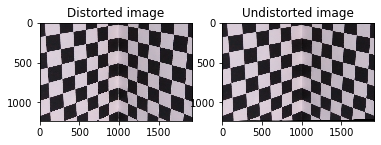

In [9]:
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Distorted image')
    plt.subplot(122)
    plt.imshow(imageUndistorted)
    plt.title('Undistorted image')
    plt.show()

## 2) Zhang's method

### Method
    - Find checkerboard corners. Our checkerboard has 6 x 8 vertices
    - The World coordinates initialized have block width of 1 (29 mm)
    - Using the checkerboard corners find the camera parameters.
    - Using the camera projection matrix obtained. Reproject the world points back to camera to form the wireframe.

In [10]:

    imageDir = './Camera_calibration_data/'
    imageName = 'IMG_54'
    initImage = 56
    listOfImages = []
    points_3D = []
    pixels_2D = []
    
    # World points
    pointsX = 6
    pointsY = 8
    x,y=np.meshgrid(range(pointsX),range(pointsY))
    world_points=np.hstack((x.reshape(pointsX * pointsY,1),y.reshape(pointsX * pointsY,1),np.zeros((pointsX * pointsY,1)))).astype(np.float32)
    world_points = world_points
    for i in range(15):
        imageNumber = '%d.JPG' % (initImage + i)
        image = cv2.imread(imageDir + imageName + imageNumber)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         print(imageNumber)
        listOfImages.append(image)
        ret, corners = cv2.findChessboardCorners(image, (pointsX, pointsY))
        
        if ret: #add points only if checkerboard was correctly detected:
            pixels_2D.append(corners) #append current 2D points
            points_3D.append(world_points) #3D points are always the same
        # print(image.shape)
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(points_3D, pixels_2D, (image.shape[1],image.shape[0]), None, None)
    

## Reprojected wireframe and reprojection of world origin

The image of world origin is similar to the original pixel values used to obtain the camera parameters 

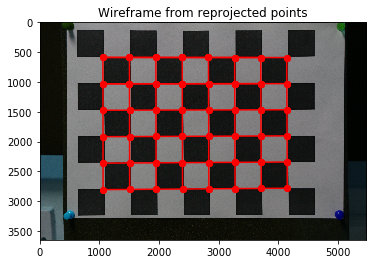

Pixel values of world origin projected on image plane
 [4143.98359528  589.83107168]
Actual world origin
 [[4149.504   579.3382]]


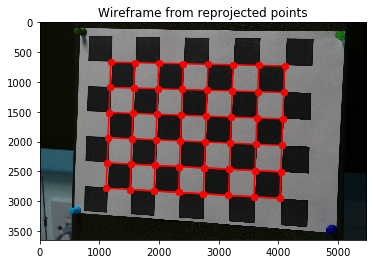

Pixel values of world origin projected on image plane
 [1115.80932424 2780.26813273]
Actual world origin
 [[1136.0684 2769.522 ]]


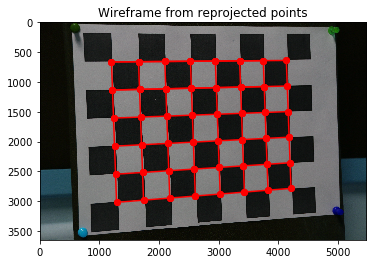

Pixel values of world origin projected on image plane
 [4137.1396293   638.56399541]
Actual world origin
 [[4145.  631.]]


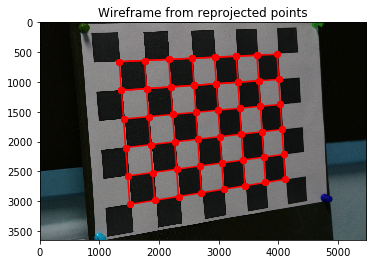

Pixel values of world origin projected on image plane
 [3980.76210253  535.12466383]
Actual world origin
 [[3988.  528.]]


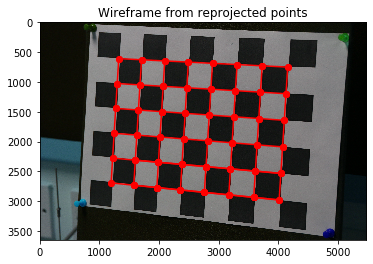

Pixel values of world origin projected on image plane
 [1197.38408931 2692.83350575]
Actual world origin
 [[1218.  2680.5]]


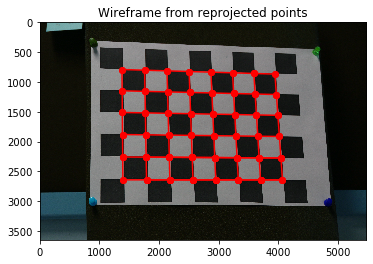

Pixel values of world origin projected on image plane
 [1394.94573599 2641.50263192]
Actual world origin
 [[1413.5583 2631.1926]]


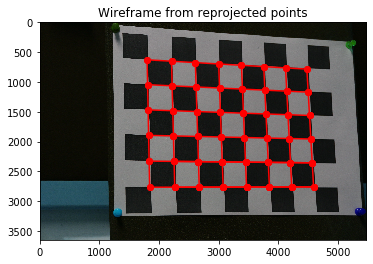

Pixel values of world origin projected on image plane
 [1844.03047321 2765.35120468]
Actual world origin
 [[1860.0323 2755.8938]]


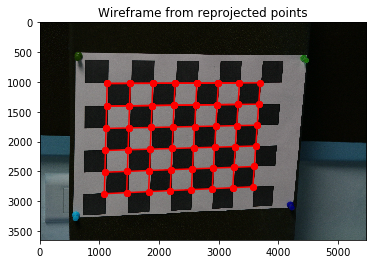

Pixel values of world origin projected on image plane
 [3699.15296252 1014.56124036]
Actual world origin
 [[3700.9749  1015.11005]]


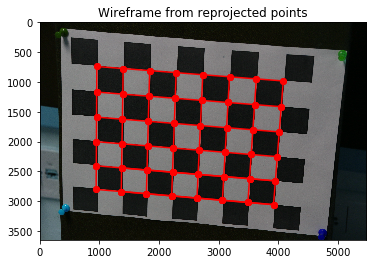

Pixel values of world origin projected on image plane
 [ 946.58425763 2801.71977545]
Actual world origin
 [[ 970.0337 2789.2532]]


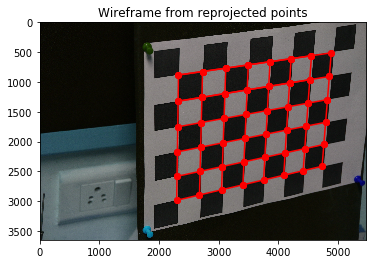

Pixel values of world origin projected on image plane
 [4890.57303609  511.22983469]
Actual world origin
 [[4918.5  496.5]]


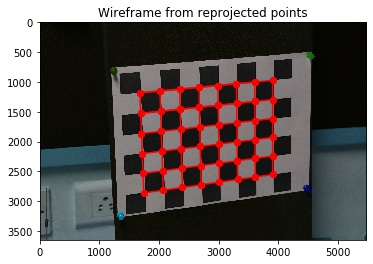

Pixel values of world origin projected on image plane
 [3906.70345207  972.35993457]
Actual world origin
 [[3909.9639   970.34393]]


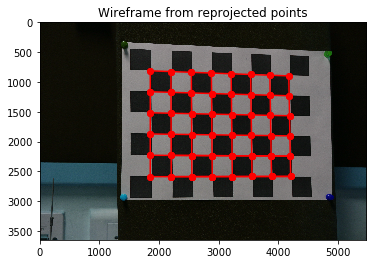

Pixel values of world origin projected on image plane
 [1854.41351089 2588.5855996 ]
Actual world origin
 [[1868.7612 2579.4883]]


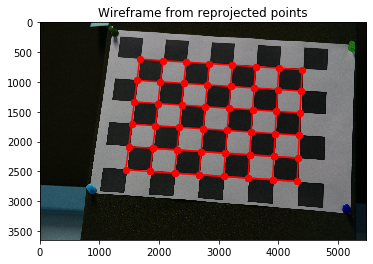

Pixel values of world origin projected on image plane
 [1443.97862545 2472.88120929]
Actual world origin
 [[1461.7867 2463.7866]]


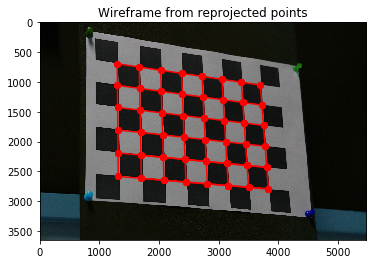

Pixel values of world origin projected on image plane
 [1317.02239743 2584.17309323]
Actual world origin
 [[1335.301  2572.2922]]


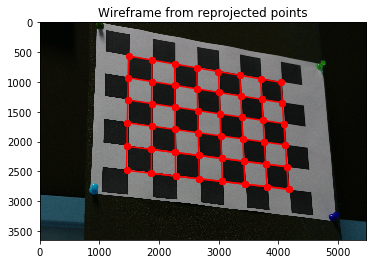

Pixel values of world origin projected on image plane
 [1456.23570377 2481.94364418]
Actual world origin
 [[1474.5028 2472.8123]]


In [11]:
    for i in range(15):
        testImage = i
        image = listOfImages[testImage]
        r = rvecs[testImage]
        t = tvecs[testImage]
        reprojectedImage(image, r, t)
        print('Actual world origin\n', pixels_2D[testImage][0,:])


## 3) Hands on

- For the hands on part I have taken images of a 5 x 5 rubik's cube and checkerboard with my phone's camera and estimated its camera parameters 

### DLT

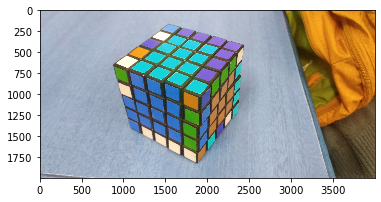

Camera intrinsic matrix
 [[-4.40686344e+03  5.96013156e+01  2.32650596e+03]
 [-0.00000000e+00 -4.35483884e+03  1.20579747e+03]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]
Rotation matrix
 [[-0.90365212  0.42545375 -0.0490097 ]
 [-0.32514778 -0.6070809   0.72507359]
 [-0.27873242 -0.67114968 -0.68692528]]
Camera center
 [-32.49563377 -56.33987692 -56.80137689]


In [12]:
    imageDir = './Xiaomi_rahul/'
    calibObject = 'cube.jpg'
    calibObjectImage = cv2.imread(imageDir + calibObject)
    plt.figure()
    plt.imshow(calibObjectImage)
    # plt.plot(pixels_2D[:,0],pixels_2D[:,1],'ro')
    plt.show()

        # points for DLT
    pixels_2D = np.array([[1913, 1017],
                          [1700,  945],
                          [1265,  790],
                          [2028,  891],
                          [2244,  624],
                          [1914, 1208],
                          [1900, 1539],
                          [1663,  448],
                          [1067,  726],
                          [2356,  514],
                          [1924, 1681],
                          [1317, 1151],
                          [2234,  984]])

    points_3D = np.array([[   0,   0,  0],
                          [   1,   0,  0],
                          [   3,   0,  0],
                          [   0,   1,  0],
                          [   0,   3,  0],
                          [   0,   0,  1],
                          [   0,   0,  3],
                          [   3,   3,  0],
                          [   4,   0,  0],
                          [   0,   4,  0],
                          [   0,   0,  4],
                          [   3,   0,  2],
                          [   0,   3,  2]])
    points_3D = points_3D * 5
    
    P, errorP = DLT(pixels_2D[1:12,:], points_3D[1:12,:])
    K, R, C = decompositionProjectionMatrix(P)
    print('Camera intrinsic matrix\n',K)
    print('Rotation matrix\n',R)
    print('Camera center\n',C)

### Zhang's Method

In [13]:
    imageDir = './Xiaomi_rahul/'
    imageName = ''
    initImage = 11
    listOfImages = []
    points_3D = []
    pixels_2D = []
    
    # World points
    pointsX = 6
    pointsY = 9
    x,y=np.meshgrid(range(pointsX),range(pointsY))
    world_points=np.hstack((x.reshape(pointsX * pointsY,1),y.reshape(pointsX * pointsY,1),np.zeros((pointsX * pointsY,1)))).astype(np.float32)
    world_points = world_points
    
    for i in range(4):
        imageNumber = '%d.jpg' % (initImage + i)
        image = cv2.imread(imageDir + imageName + imageNumber)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         print(imageNumber)
#         print(imageDir + imageName + imageNumber)
        listOfImages.append(image)
        
        ret, corners = cv2.findChessboardCorners(image, (pointsX, pointsY))
        print(ret)
        if ret: #add points only if checkerboard was correctly detected:
            pixels_2D.append(corners) #append current 2D points
            points_3D.append(world_points) #3D points are always the same

        # print(image.shape)
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(points_3D, pixels_2D, (image.shape[1],image.shape[0]), None, None)
    print(ret)

True
True
True
True
1.1499836725996024


In [14]:
    print('\nReprojection Error:', ret)
    print ('\nCamera Calibration Matrix:')
    print(K)
    print('\nDistortion Parameters:')
    print(dist)
    print('\nRotation Vectors for the images are:')
    print(rvecs)
    print('\nTranslation Vectors for the images are:')
    print(tvecs)


Reprojection Error: 1.1499836725996024

Camera Calibration Matrix:
[[3.18767572e+03 0.00000000e+00 2.02449026e+03]
 [0.00000000e+00 3.17982610e+03 1.04695367e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Parameters:
[[ 1.68638013e-01 -7.66486796e-01  1.07639992e-03  2.06996970e-03
   1.09105453e+00]]

Rotation Vectors for the images are:
[array([[ 0.13725004],
       [ 0.35099976],
       [-1.56520311]]), array([[ 0.09096391],
       [ 0.2932277 ],
       [-1.55134411]]), array([[ 0.21637531],
       [-0.04649714],
       [-1.58955746]]), array([[-0.0377565 ],
       [ 0.26358169],
       [-1.54437205]])]

Translation Vectors for the images are:
[array([[-6.20949746],
       [ 1.43887876],
       [15.67218912]]), array([[-6.716477  ],
       [ 1.46993186],
       [15.8056301 ]]), array([[-5.86392508],
       [ 2.33494497],
       [12.80942266]]), array([[-6.26253456],
       [ 2.09655379],
       [13.68244669]])]


### Part(a) Comparing Zhang's method of obtaining camera parameters and DLT

- We see that there is a change in the fx and fy values of camera intrinsic matrix obtained using Zhang's method and DLT method. This can occur due to the fact that choosing pixel points can be erroneous. This results in a small difference between fx and fy of camera intrinsic matrix computed in the two cases.
- Zhang's method works better as this erradicates human error.



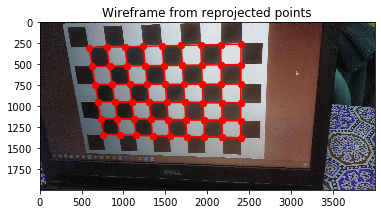

Pixel values of world origin projected on image plane
 [ 761.49731589 1338.89656807]


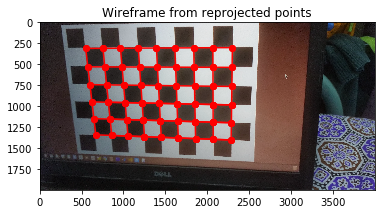

Pixel values of world origin projected on image plane
 [ 669.91277702 1342.67916379]


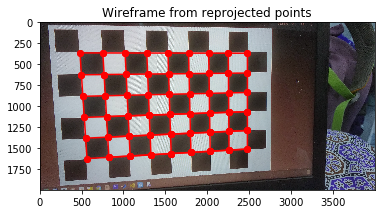

Pixel values of world origin projected on image plane
 [ 565.22920703 1626.58315133]


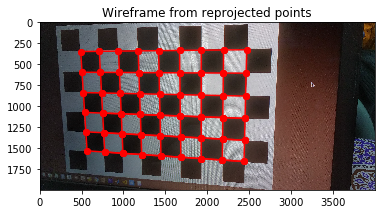

Pixel values of world origin projected on image plane
 [ 565.47274728 1534.19668123]


In [15]:
    for i in range(4):
        testImage = i
        image = listOfImages[testImage]
        r = rvecs[testImage]
        t = tvecs[testImage]
        reprojectedImage(image, r, t)

### Part(b) Changing the focus (depth of field) by varying aperture

- We see that after changing the focus the fx and fy values of the camera intrinsic matrix K is slightly changed. This happens because the camera adjusts its focal length depending on where the user wishes to focus or sometimes changing aperture also changes the projection of world point on the image plane.
- If we try to zoom on an object the world points projected on the image plane change this is also caused due to the change in the focal length of lens and camera center. This results in the same world point projecting on a different pixel value caused due to zooming of lens. 

In [16]:
    imageDir = './Xiaomi_rahul_changed_focus/'
    imageName = ''
    initImage = 1
    listOfImages = []
    points_3D = []
    pixels_2D = []
    
    # World points
    pointsX = 6
    pointsY = 9
    x,y=np.meshgrid(range(pointsX),range(pointsY))
    world_points=np.hstack((x.reshape(pointsX * pointsY,1),y.reshape(pointsX * pointsY,1),np.zeros((pointsX * pointsY,1)))).astype(np.float32)
    world_points = world_points
    
    for i in range(5):
        imageNumber = '%d.jpg' % (initImage + i)
        image = cv2.imread(imageDir + imageName + imageNumber)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         print(imageNumber)
#         print(imageDir + imageName + imageNumber)
        listOfImages.append(image)
        
        ret, corners = cv2.findChessboardCorners(image, (pointsX, pointsY))
        print(ret)
        if ret: #add points only if checkerboard was correctly detected:
            pixels_2D.append(corners) #append current 2D points
            points_3D.append(world_points) #3D points are always the same

        # print(image.shape)
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(points_3D, pixels_2D, (image.shape[1],image.shape[0]), None, None)
    print(ret)
    

True
True
True
True
True
1.3504550329458078


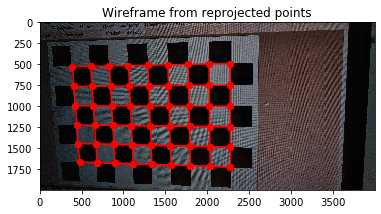

Pixel values of world origin projected on image plane
 [ 475.54734413 1667.30472392]


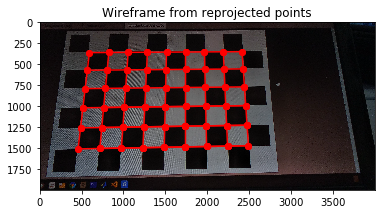

Pixel values of world origin projected on image plane
 [ 458.25831349 1510.68646689]


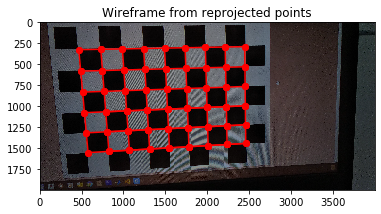

Pixel values of world origin projected on image plane
 [ 577.3306656  1555.21766577]


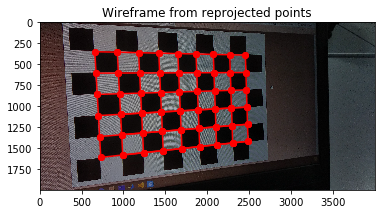

Pixel values of world origin projected on image plane
 [ 729.71150971 1612.17796663]


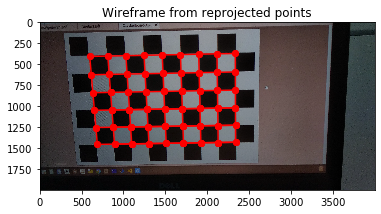

Pixel values of world origin projected on image plane
 [ 688.2816222  1456.99198968]


In [17]:
    for i in range(5):
        testImage = i
        image = listOfImages[testImage]
        r = rvecs[testImage]
        t = tvecs[testImage]
        reprojectedImage(image, r, t)

In [18]:
    print('Printing obtained parameters after changing focus')
    print('\nReprojection Error:', ret)
    print ('\nCamera Calibration Matrix:')
    print(K)
    print('\nDistortion Parameters:')
    print(dist)
    print('\nRotation Vectors for the images are:')
    print(rvecs)
    print('\nTranslation Vectors for the images are:')
    print(tvecs)

Printing obtained parameters after changing focus

Reprojection Error: 1.3504550329458078

Camera Calibration Matrix:
[[3.13700274e+03 0.00000000e+00 2.00221049e+03]
 [0.00000000e+00 3.14134925e+03 1.02417213e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Parameters:
[[ 1.59815443e-01 -7.26218088e-01 -8.25738503e-04  1.68524564e-03
   1.03947695e+00]]

Rotation Vectors for the images are:
[array([[-0.01022189],
       [ 0.20191219],
       [-1.57139984]]), array([[-0.20261141],
       [-0.25459206],
       [-1.57713367]]), array([[ 0.18739353],
       [ 0.01462499],
       [-1.60263866]]), array([[ 0.31710919],
       [-0.25639797],
       [-1.59723568]]), array([[ 0.11135657],
       [ 0.13208584],
       [-1.58586148]])]

Translation Vectors for the images are:
[array([[-6.7949956 ],
       [ 2.8585458 ],
       [13.96242509]]), array([[-6.03081098],
       [ 1.89773773],
       [12.25340451]]), array([[-5.91716632],
       [ 2.20224675],
       [13.02718071]]), ar